<a href="https://colab.research.google.com/github/baker371/hash/blob/main/HASH_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#!pip install pycaret

#!pip install pandas-profiling xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pycaret
from   pycaret.classification import *
np.random.seed(42)
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from google.colab import drive
from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
tokeep = pd.read_csv('gdrive/MyDrive/datasets/tokeep_uphia.csv')
tokeep.head()

wanted
0  adcnloc_a
1  adcnloc_b
2  adcnloc_c
3  adcnloc_x
4  adcnloc_y

In [25]:
wanted = tokeep['wanted'].tolist()
wanted

['adcnloc_a',
 'adcnloc_b',
 'adcnloc_c',
 'adcnloc_x',
 'adcnloc_y',
 'adlvlsch',
 'admedll',
 'age',
 'cookingfuel',
 'educationuganda',
 'gender',
 'havetele',
 'havmobl',
 'healthc',
 'hhrmarital',
 'known_hiv_status',
 'occuptn',
 'region',
 'religion',
 'sexever',
 'sick3mo',
 'urban',
 'wealthquintile',
 'adcnloc',
 'hivtstlocation',
 'watersource',
 'householdid',
 'personid',
 'centroidid']

In [26]:
uphia = pd.read_csv('gdrive/MyDrive/datasets/uphia2016.csv')
uphia.head()

country     householdid          personid centroidid  region  indstatus  gender  age  relattohh  livehere  ...    vmpstw249    vmpstw250    vmpstw251    vmpstw252    vmpstw253    vmpstw254    vmpstw255    vmpstw256    vmpstw257    vmpstw258
0  Uganda  UG000000000001  UG00000000000101   UG000353       1          1       2   50          1         1  ...          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN
1  Uganda  UG000000000001  UG00000000000102   UG000353       1          1       2   19          4         1  ...  1997.888985  2009.710180  2002.007974  2003.680838  1999.723921  1993.404505  1990.006687  2015.793228  2001.792077  2023.411812
2  Uganda  UG000000000002  UG00000000000201   UG000279       7          1       2   32          1         1  ...          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN
3  Uganda  UG000000000002  UG00000000000206   UG000279       7          1       2   15          3         1  ...          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN
4  Uganda  UG000000000002  UG00000000000209   UG000279       7          1       1   24         10         1  ...  2131.697759  2109.104596  2128.709771  2131.719277  2135.534547  2135.593822  2138.387861  2117.248815  2139.532580  2121.673522

[5 rows x 902 columns]

In [27]:
uphia = uphia.drop_duplicates()
uphia.shape

(34716, 902)

In [28]:
# remove children

uphia= uphia[uphia['age'] > 17]
uphia.shape

(30566, 902)

In [29]:
# Dropping columns contained in the 'unwanted' list
df = uphia[[col for col in uphia.columns if col in wanted]]
df.shape

(30566, 17)

In [9]:
df.head()

householdid          personid centroidid  region  gender  age  sick3mo  occuptn  religion  hivtstlocation  healthc  urban  known_hiv_status  wealthquintile  educationuganda  hhrmarital  sexever
0  UG000000000001  UG00000000000101   UG000353       1       2   50      2.0      4.0       2.0            21.0      NaN      2               2.0             4.0                3           4        1
1  UG000000000001  UG00000000000102   UG000353       1       2   19      2.0      5.0       1.0             5.0      NaN      2               2.0             4.0                2           5        1
2  UG000000000002  UG00000000000201   UG000279       7       2   32      2.0      NaN       7.0             3.0      1.0      2               2.0             4.0                2           1        1
4  UG000000000002  UG00000000000209   UG000279       7       1   24      2.0      NaN       7.0             5.0      NaN      2               2.0             4.0                2           2        1
6  UG000000000002  UG00000000000211   UG000279       7       2   20      2.0      NaN       7.0             5.0      NaN      2               2.0             4.0                2           5        1

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30566 entries, 0 to 34715
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   householdid       30566 non-null  object 
 1   personid          30566 non-null  object 
 2   centroidid        30566 non-null  object 
 3   region            30566 non-null  int64  
 4   gender            30566 non-null  int64  
 5   age               30566 non-null  int64  
 6   sick3mo           28460 non-null  float64
 7   occuptn           14502 non-null  float64
 8   religion          26191 non-null  float64
 9   hivtstlocation    21826 non-null  float64
 10  healthc           16824 non-null  float64
 11  urban             30566 non-null  int64  
 12  known_hiv_status  26498 non-null  float64
 13  wealthquintile    30565 non-null  float64
 14  educationuganda   30566 non-null  int64  
 15  hhrmarital        30566 non-null  int64  
 16  sexever           30566 non-null  int64 

In [31]:
#Mode imputation for dealing with missing values
df = df.fillna(df.mode().iloc[0])

In [32]:
# Data Labellling

df['outcome'] = 0

df.loc[(df['wealthquintile']>3) | (df['occuptn'].isin([1,2,3,4])), 'outcome'] = 1


<AxesSubplot: ylabel='Density'>

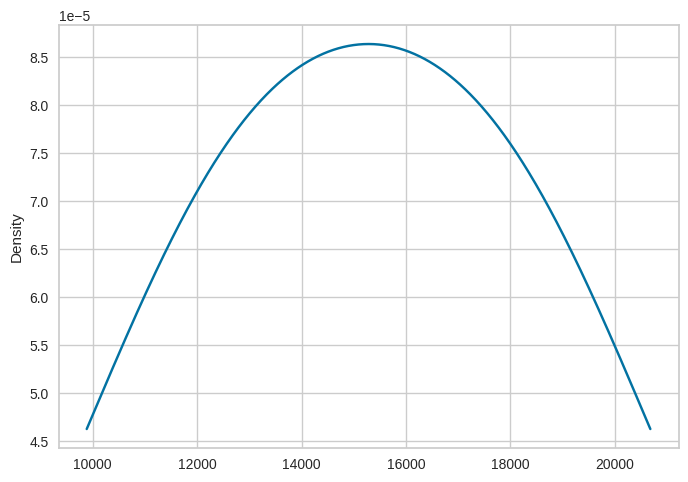

In [33]:
# Target/Dependent variable is the Outcome Column. It shows if someone will be able to buy (1) or not (0)

df.outcome.value_counts().plot(kind= "density")

In [34]:
# Show Report
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
# Data Clean up

# Remove duplicates

df = df.drop(['householdid','personid','centroidid','sick3mo','occuptn','healthc'], axis=1)

df.shape

(30566, 12)

In [15]:
# Renaming columns
df = df.rename(columns={'hivtstlocation': 'service_location', 'educationuganda': 'education_level', 'hhrmarital': 'marital_status','sexever':'sexually_active'})
df.to_csv('uphia_sample.csv', index=False)

In [16]:
# Setting our source data source, with the target as disease. The model will be split on 80 training and 20 testing

try:
    clf = setup(data=df, target='outcome', train_size=0.8, fold_shuffle=True, session_id=2)
except AttributeError:
    pass

In [17]:
# Finding the best model by sorting out the highest area under the curve (AUC)

compare_models(sort='AUC')

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [18]:
gbc = create_model('gbc')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
tuned_gbc = tune_model(gbc, optimize='AUC')
tuned_gbc

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='log_loss', max_depth=7,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.002, min_samples_leaf=5,
                           min_samples_split=9, min_weight_fraction_leaf=0.0,
                           n_estimators=270, n_iter_no_change=None,
                           random_state=2, subsample=0.65, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
# launch evaluate widget

evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [21]:
# The test consists of remaining 20% of data that PyCaret automatically split on the setup, it's important to see that the model is not overfitting.

predict_model(tuned_gbc)

region  gender  age  religion  service_location  urban  known_hiv_status  wealthquintile  education_level  marital_status  sexually_active  outcome  prediction_label  prediction_score
34545       3       2   48       1.0               5.0      1               2.0             5.0                4               1                1        1                 1            0.9606
12136       5       1   80       NaN               NaN      2               NaN             4.0               99              99               99        1                 1            0.9606
14794       9       2   29       3.0               5.0      2               2.0             3.0                2               3                1        0                 0            0.8960
10473       1       1   39       1.0               5.0      1               2.0             5.0                5               1                1        1                 1            0.9606
10814       1       2   27       7.0               5.0      2               2.0             4.0                4               1                1        1                 1            0.9606
...       ...     ...  ...       ...               ...    ...               ...             ...              ...             ...              ...      ...               ...               ...
23843       2       1   37       5.0              12.0      2               2.0             3.0                2               1                1        1                 0            0.8344
10707       5       2   45       3.0              12.0      2               2.0             2.0                3               1                1        1                 0            0.8868
12114       1       2   30       1.0               5.0      1               1.0             4.0                2               1                1        1                 1            0.9606
9143        8       2   28       1.0              12.0      2               2.0             1.0                4               1                1        0                 0            0.8051
9625        1       2   42       1.0               5.0      1               1.0             5.0                2               4                1        1                 1            0.9606

[6114 rows x 14 columns]

In [22]:
# Save the model

try:
    save_model(tuned_gbc, 'hash_gbc')
except AttributeError:
    pass

Transformation Pipeline and Model Successfully Saved
